In [26]:
import pandas as pd
import numpy as np
from collections import Counter
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 파일 선택을 통해 예제 데이터를 내 컴퓨터에서 불러옵니다.
from google.colab import files
uploaded = files.upload()
my_data = 'medical_checkup_mean.csv'


Saving medical_checkup_mean.csv to medical_checkup_mean (1).csv


In [3]:
# dataset을 불러옵니다.

cg = pd.read_csv(my_data)

cg_df = pd.DataFrame(cg)

del cg_df['Unnamed: 0']

cg_df = cg_df.sort_values(by=['person_id','test_age'])

#### 여러 회차에 걸친 위염환자들의 건강검진 데이터

In [4]:
cg_df

,person_id,gender,age,bmi,smoking status,smoking_duration,amount of smoking,alcohol_habit,income,family_cancer,test_age,cancer
0,10224187,0,75,17.360000,3.0,5,2,1.0,2.0,1,64,0
1,10224187,0,75,17.360000,3.0,1,2,1.0,2.0,1,64,0
2,10410714,0,70,28.010000,3.0,5,4,1.0,7.0,1,59,1
3,10410714,0,70,25.510000,3.0,4,1,1.0,7.0,1,63,1
4,10485977,0,53,27.460000,3.0,4,3,4.0,10.0,1,45,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1044,53078031,0,80,23.457522,3.0,5,3,1.0,8.0,1,69,1
1045,53346919,0,76,20.830000,3.0,5,3,1.0,5.0,1,61,0
1046,53369201,0,74,23.457522,3.0,4,1,1.0,7.0,1,56,1
1047,53369201,0,74,23.457522,3.0,5,1,1.0,8.0,1,58,1


In [5]:
cg_df.columns

Index(['person_id', 'gender', 'age', 'bmi', 'smoking status',
       'smoking_duration', 'amount of smoking', 'alcohol_habit', 'income',
       'family_cancer', 'test_age', 'cancer'],
      dtype='object')

### y_label 생성 
##### 한사람 당 여러 회차의 기록이 있어 person_id와 cancer 여부가 중복 되므로 
##### 이를 고려하여 중복을 제거하여 레이블을 생성

In [6]:
# Y_label

cg_y = cg_df.loc[:,['person_id','cancer']]
cg_y = cg_y.drop_duplicates(['person_id'])

y_label = cg_y['cancer']

In [7]:
cg_y

,person_id,cancer
0,10224187,0
2,10410714,1
4,10485977,0
5,10486529,0
8,10879002,0
...,...,...
1039,52430195,0
1042,52560487,0
1044,53078031,1
1045,53346919,0


In [8]:
# y_label
Counter(y_label)

Counter({0: 250, 1: 250})

### 전처리 단계
##### 수치형 변수에 대해 범주형 변수와 비교할 때 값의 차이가 크므로
##### 이를 보완하기 위해 정규형으로 변환하는 전처리를 실시

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [10]:
def pipeline(df, nums, cats):

    num_pipeline=Pipeline([
        ("select_numeric",DataFrameSelector(nums)),
        ("scaler", StandardScaler())])

    cat_pipeline = Pipeline([
        ("select_cat",DataFrameSelector(cats))])
    
    preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)])
    
    X=preprocess_pipeline.fit_transform(df)
    
    return X

In [11]:
cats=['bmi','age','test_age']
nums=['gender','smoking status','smoking_duration','amount of smoking','alcohol_habit','income','family_cancer']

### 2차원 데이터를 3차원으로 변환하는 과정
##### 환자의 개인별  n년치 건강검진 데이터이므로,
##### 환자별로 학습이 이뤄지기 위해서 기존 표 형식과 같은 2차원 데이터에서
##### 시간의 순서를 고려한 3차원 데이터로의 변환이 필요함.

In [12]:
def make_metrics(df, X):
    
    person_id = df['person_id']
    ids = person_id.iloc[0]
    new_mat = []
    person=[]

    for i in range(len(df)):  
        if ids == person_id.iloc[i]:
            person.append(X[i])
            ids = person_id.iloc[i]
        else:
            new_mat.append(person)
            person=[]
            person.append(X[i])
            ids = person_id.iloc[i]
    new_mat.append(person)
    
    return new_mat

### Padding & Convert to tensor
##### 올바른 RNN 학습을 위해 가변길이의 데이터를 같은 길이로 늘려주는 작업(padding)과
##### array 형태의 데이터 형식을 RNN 학습에 용이한 Tensor로 변환하는 과정

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
def convert(new_mat):
    
    max_len=0
    for data in new_mat:
        if len(data)>max_len:
            max_len = len(data)

    X_data = pad_sequences(new_mat, padding='post',value=-1, maxlen=max_len, dtype='float32')
    X_data = tf.convert_to_tensor(X_data)
    
    return X_data

In [15]:
# Pretreatment
X = pipeline(cg_df,nums, cats)

# convert to 3D Array
new_mat = make_metrics(cg_df, X)

# Padding & Conver to tensor
X_data = convert(new_mat)

In [16]:
X_data.shape

TensorShape([500, 10, 10])

### Train / Test data

In [17]:
from tensorflow.keras.utils import to_categorical

In [18]:
train_x = X_data[:int(0.7*len(X_data))]
test_x = X_data[int(0.7*len(X_data)):]

train_y = y_label[:int(0.7*len(X_data))]
test_y = y_label[int(0.7*len(X_data)):]

train_y1 = to_categorical(train_y)
test_y1 = to_categorical(test_y)

In [19]:
print('Train data : %d' %len(train_x))
print('Test data : %d' %len(test_x))

print('Train data label => %s' %Counter(train_y))
print('Test data label => %s' %Counter(test_y))

Train data : 350
Test data : 150
Train data label => Counter({0: 176, 1: 174})
Test data label => Counter({1: 76, 0: 74})


### RNN Model

In [20]:
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

In [21]:
model = Sequential()
model.add(SimpleRNN(32, input_shape=(train_x.shape[1:]),return_sequences=True))
model.add(SimpleRNN(32, return_sequences=False))
model.add(Dense(2, activation='softmax'))

In [22]:
model = Sequential()
model.add(LSTM(32, input_shape=(train_x.shape[1:]),return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(2, activation='softmax'))

In [23]:
# RNN Model Summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 32)            5504      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 13,890
Trainable params: 13,890
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer=RMSprop(),loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(train_x,train_y1,epochs=100,batch_size=64,validation_split=0.2)

Epoch 1/100
5/5 [==============================] - 1s 197ms/step - loss: 0.6895 - accuracy: 0.5714 - val_loss: 0.6695 - val_accuracy: 0.5429
Epoch 2/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6698 - accuracy: 0.5679 - val_loss: 0.6344 - val_accuracy: 0.7143
Epoch 3/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6353 - accuracy: 0.6821 - val_loss: 0.6079 - val_accuracy: 0.7429
Epoch 4/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6240 - accuracy: 0.6500 - val_loss: 0.5860 - val_accuracy: 0.7429
Epoch 5/100
5/5 [==============================] - 0s 13ms/step - loss: 0.6068 - accuracy: 0.6893 - val_loss: 0.6170 - val_accuracy: 0.6571
Epoch 6/100
5/5 [==============================] - 0s 13ms/step - loss: 0.5897 - accuracy: 0.6571 - val_loss: 0.5650 - val_accuracy: 0.7143
Epoch 7/100
5/5 [==============================] - 0s 12ms/step - loss: 0.5868 - accuracy: 0.6714 - val_loss: 0.5600 - val_accuracy: 0.7143
Epoch 8/100
5/5 [==

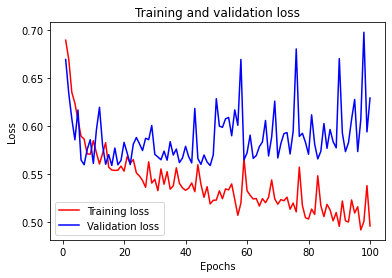

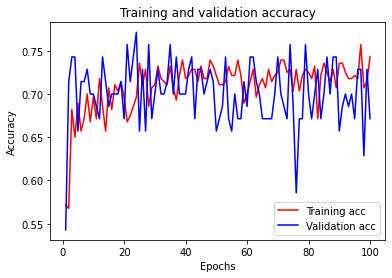

In [27]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')  
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Confusion Matrix

In [28]:
from sklearn.metrics import confusion_matrix,classification_report

In [29]:
test_pred = model.predict_classes(test_x)

test_pred = [a for a in test_pred]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
#test_pred

In [30]:
print('predict label => %s' %Counter(test_pred))
print('real label => %s' %Counter(test_y))

predict label => Counter({1: 78, 0: 72})
real label => Counter({1: 76, 0: 74})


In [31]:
print(confusion_matrix(test_y,test_pred,labels=[1,0]))

[[52 24]
 [26 48]]


In [32]:
print(classification_report(test_y,test_pred))

              precision    recall  f1-score   support

           0       0.67      0.65      0.66        74
           1       0.67      0.68      0.68        76

    accuracy                           0.67       150
   macro avg       0.67      0.67      0.67       150
weighted avg       0.67      0.67      0.67       150



### ROC Curve & AUC

In [33]:
import matplotlib as mpl
from sklearn import metrics

0.7263513513513513


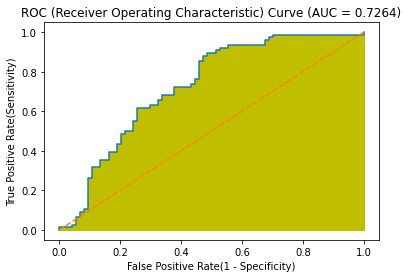

In [34]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, model.predict(test_x)[:,1]) #곡선 그리기

plt.plot(fpr, tpr)
plt.fill_between(fpr, tpr, color='y')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')

score = metrics.auc(fpr, tpr) #면적 구하기
print(score) #1.0

plt.title('ROC (Receiver Operating Characteristic) Curve (AUC = {})'.format(round(score,4)))
plt.show()